In [1]:
import sys, os

from glob import glob
from tqdm import tqdm
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from matplotlib.image import imread

#tf.enable_eager_execution()

2023-11-05 13:21:12.485220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = "/Users/taikisakai/github/TransferLearning-CNN-/dataset"
train_dir = os.path.join(data_dir, "train")#tfrecordsの出力先
test_dir = os.path.join(data_dir, "test")
img_size = 200
img_channels = 3
num_classes = 3
class_names = ["Crazing", "Inclusion", "Patches"]
extension = "*.bmp" 


In [3]:
#学習データのパスを取得する
def data_import(class_names, extension, src):
    X_images = []
    Y_labels = []

    #total classn number in the dataset
    class_index_num = 0
    class_numbers_index = []
    with tqdm(enumerate(class_names), 
              total=len(class_names), 
              ncols=70, 
              ascii=True) as load:
        
        for index, name in load:
            read_data = src + "/" + name 
            for file_path in glob(os.path.join(read_data, extension)):
                X_images.append(file_path)
                Y_labels.append(int(index))
                class_numbers_index.append(index)

            class_index_num += 1

        class_numbers_index = np.asarray(class_numbers_index)
        Y_labels = class_numbers_index

        print("All images has been imported correctly")

        return X_images, Y_labels



In [4]:
X_train, Y_train = data_import(class_names, extension, train_dir)
X_test, Y_test = data_import(class_names, extension, test_dir)

100%|###################################| 3/3 [00:00<00:00, 91.15it/s]


All images has been imported correctly


100%|##################################| 3/3 [00:00<00:00, 400.86it/s]

All images has been imported correctly


In [5]:
print(len(X_train))
print(len(X_test))

828
36


In [6]:
print(X_train[0])

/Users/taikisakai/github/TransferLearning-CNN-/dataset/train/Crazing/Cr_87.bmp


In [7]:
train_img = tf.data.Dataset.from_tensor_slices(X_train)
train_label = tf.data.Dataset.from_tensor_slices(tf.cast(Y_train, tf.uint8))
train_paths = tf.data.Dataset.zip((train_img, train_label)).shuffle(1000)

test_img = tf.data.Dataset.from_tensor_slices(X_test)
test_label = tf.data.Dataset.from_tensor_slices(tf.cast(Y_test, tf.uint8))
test_paths = tf.data.Dataset.zip((test_img, test_label)).shuffle(1000)

In [8]:
cnt = 0
for img, label in enumerate(train_paths):
    cnt += 1
    print(img)
    print(label)
    if cnt == 10:
        break

0
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/taikisakai/github/TransferLearning-CNN-/dataset/train/Crazing/Cr_132.bmp'>, <tf.Tensor: shape=(), dtype=uint8, numpy=0>)
1
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/taikisakai/github/TransferLearning-CNN-/dataset/train/Crazing/Cr_274.bmp'>, <tf.Tensor: shape=(), dtype=uint8, numpy=0>)
2
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/taikisakai/github/TransferLearning-CNN-/dataset/train/Crazing/Cr_17.bmp'>, <tf.Tensor: shape=(), dtype=uint8, numpy=0>)
3
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/taikisakai/github/TransferLearning-CNN-/dataset/train/Patches/Pa_163.bmp'>, <tf.Tensor: shape=(), dtype=uint8, numpy=2>)
4
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/taikisakai/github/TransferLearning-CNN-/dataset/train/Patches/Pa_28.bmp'>, <tf.Tensor: shape=(), dtype=uint8, numpy=2>)
5
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/taikisakai/github/TransferLearning-CNN-/dataset/train/Patches/Pa_244.bmp'

In [9]:
def print_progress(count, total):
    pct_complete = float(count) / total
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

In [10]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [14]:
def convert2int(data_path, out_path):
    print("converting:" + out_path)
    num_images = 828

    with tf.io.TFRecordWriter(out_path) as writer:
        for i, (path, label) in enumerate(data_path):
            print_progress(i, num_images-1)
            img_path = path.numpy().decode('utf-8')
            #print("---")
            img = imread(img_path, 'rgb')
            img_bytes = img.tobytes()

            label = label.numpy()
            label = np.eye(3).astype(np.float32)[label]
            label_bytes = label.tobytes()

            data = {'image':wrap_bytes(img_bytes), 'label':wrap_bytes(label_bytes)}
            feature = tf.train.Features(feature=data)
            example = tf.train.Example(features=feature)
            serialized = example.SerializeToString()
            writer.write(serialized)

In [15]:
tfrecords_train = os.path.join(train_dir, "train_tfrecords")
tfrecords_test = os.path.join(test_dir, "test_tfrecords")

In [17]:
convert2int(data_path=train_paths, out_path=tfrecords_train)
convert2int(data_path=test_paths, out_path=tfrecords_test)

converting:/Users/taikisakai/github/TransferLearning-CNN-/dataset/train/train_tfrecords
- Progress: 0.0%

(200, 200)


SystemExit: 0

In [18]:
count = 1
img_list = []
label_list = []
TFRECORDS = "/Users/taikisakai/github/TransferLearning-CNN-/dataset/train_tfrecords"
for record in tf.python_io.tf_record_iterator(TFRECORDS):
    example = tf.train.Example()
    example.ParseFromString(record)

    image = example.features.feature["image"].bytes_list.value[0]
    label = example.features.feature["label"].bytes_list.value[0]

    label = np.fromstring(label, dtype=np.float32)
    label_list.append(label)

    image = np.fromstring(image, dtype=np.uint8)
    image = image.reshape([200, 200, 3])

    img = np.array(image)
    img_list.append(img)

    count += 1

    if count == 300:
        break
"""
for record in tf.data.TFRecordDataset(TFRECORDS):
    example = tf.train.Example()
    example.ParseFromString(record)
"""

/Users/taikisakai/miniconda3/envs/tf_1/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == "":
/Users/taikisakai/miniconda3/envs/tf_1/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  from ipykernel import kernelapp as app


'\nfor record in tf.data.TFRecordDataset(TFRECORDS):\n    example = tf.train.Example()\n    example.ParseFromString(record)\n'

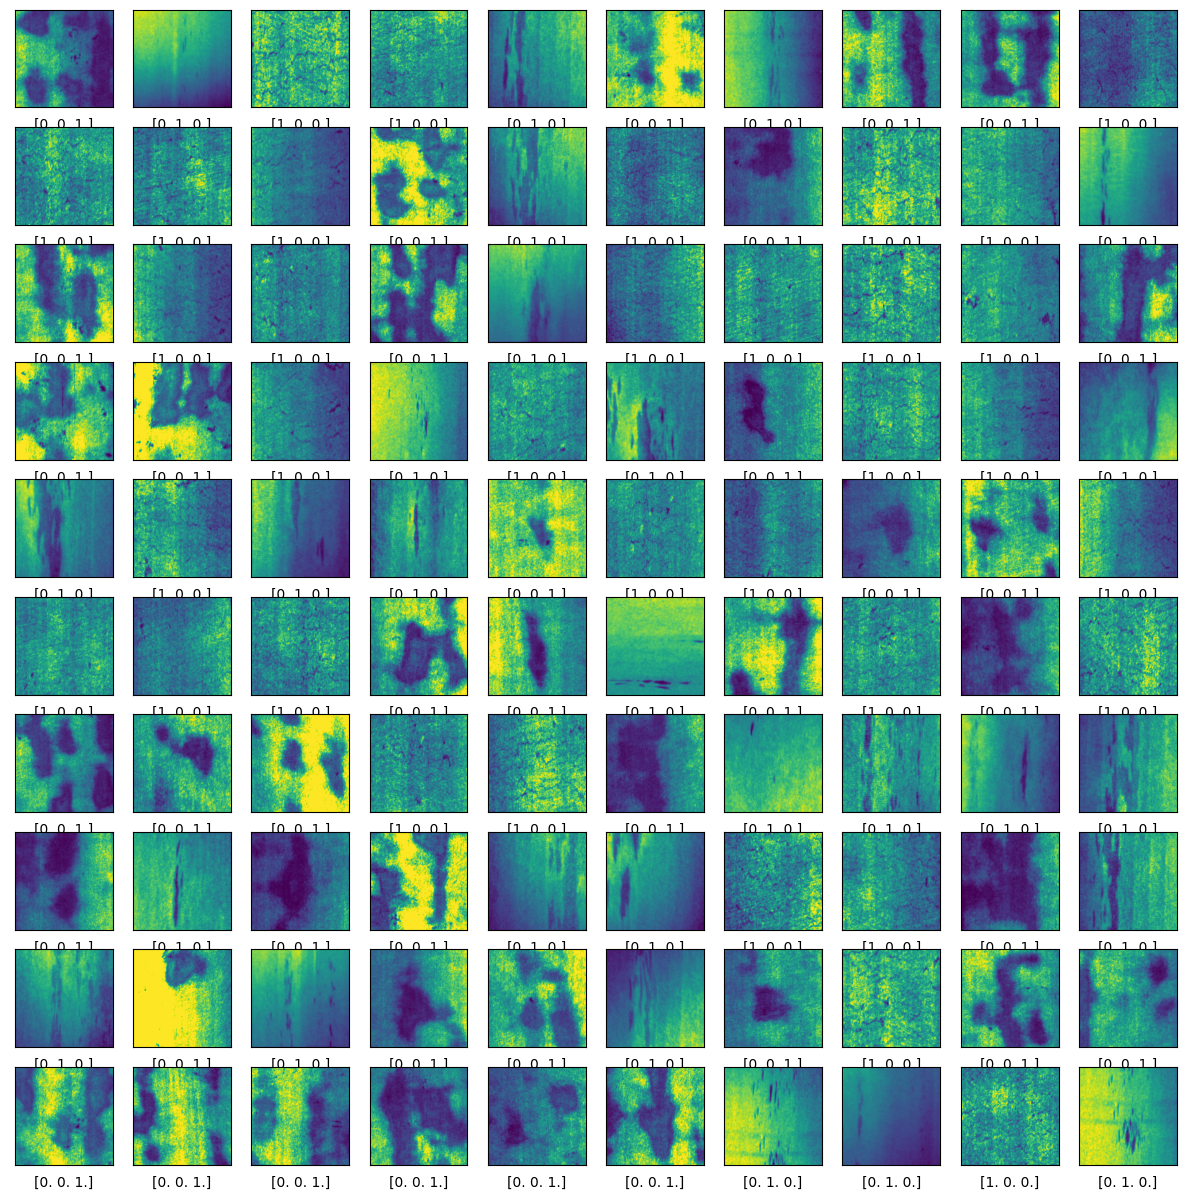

In [10]:
try:
    cnt = 0
    iterator_img = iter(img_list)
    iterator_label = iter(label_list)
    plt.figure(figsize=(15, 15))

    for i in range(300):
        cnt += 1
        img = next(iterator_img)
        label = next(iterator_label)

        plt.subplot(10, 10, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(str(label))
        plt.imshow(img)

    plt.tight_layout
    plt.show()

except ValueError:
    plt.show()

except StopIteration:
    plt.show()
    

In [14]:
img = next(iterator_img)
print(img.shape)

(200, 200)


In [27]:
img = plt.imread("/Users/taikisakai/github/TransferLearning-CNN-/dataset/train/Crazing/Cr_87.bmp",  0)

In [29]:
print(img.shape)
img = np.array(img)

(200, 200)


In [30]:
print(img.shape)

(200, 200)
